# <center>Time Series and Statistical Arbitrage HW3 ---- Volatility Forecasting</center>

&copy; Kaiwen Zhou 2023

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint

# Exercise 1: Estimating GARCH-Type Models

Using SPY data (the S&P 500 ETF) from February 1, 1993, to October 20, 2023, you will estimate the parameters of a few GARCH-type models. This exercise requires building the models from scratch rather than using a package.


<span style="color:blue">**Ended up being a data snooping challenge. LMAO.**</span>

In [18]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Other necessary libraries for GARCH modeling

In [4]:
# Download SPY data
spy_data = yf.download("SPY", start='1993-02-01', end='2023-10-21')
returns = spy_data['Adj Close'].pct_change().dropna()  # Calculate returns

[*********************100%%**********************]  1 of 1 completed


In [91]:
returns, returns.shape

(Date
 1993-02-02    0.002119
 1993-02-03    0.010570
 1993-02-04    0.004185
 1993-02-05   -0.000694
 1993-02-08    0.000000
                 ...   
 2023-10-16    0.010521
 2023-10-17   -0.000046
 2023-10-18   -0.013325
 2023-10-19   -0.008786
 2023-10-20   -0.012288
 Name: Adj Close, Length: 7736, dtype: float64,
 (7736,))

### Part (a): GARCH(1,1) Model

- Estimate the parameters of a **GARCH(1,1) model**.
- Compute the maximum value of the likelihood function.

The **GARCH(1,1)** model can be represented as:

$$ r_t = \mu + a_t, \quad a_t = \sigma_t \epsilon_t, \quad \sigma_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \beta_1 \sigma_{t-1}^2 $$

Where:

- $r_t$ are the returns.
- $\mu$ is the mean of returns.
- $a_t$ is the residual at time t.
- $\sigma_t$ is the volatility (standard deviation) at time t.
- $\alpha_0, \alpha_1, \beta_1$ are parameters to be estimated.
- $\epsilon_t$ is a standard normal random variable.

The likelihood function for **GARCH(1,1)** can be represented as:

$$L(\alpha_0, \alpha_1, \beta_1, \mu) = \prod_{t=1}^{T} \frac{1}{\sqrt{2\pi} \sigma_t} \exp\left(-\frac{(r_t - \mu)^2}{2 \sigma_t^2}\right)
\quad \Longrightarrow\quad 
\ln L(\alpha_0, \alpha_1, \beta_1, \mu) = -\frac{T}{2} \ln(2\pi) - \frac{1}{2}\sum_{t=1}^{T} \ln(\sigma_t^2) - \frac{1}{2}\sum_{t=1}^{T}\left(\frac{(r_t - \mu)^2}{\sigma_t^2}\right)
\quad \Longrightarrow\quad 
\ln L(\alpha_0, \alpha_1, \beta_1, \mu) = -\frac{T}{2} \ln(2\pi) - \frac{1}{2}\sum_{t=1}^{T} \ln(\alpha_0 + \alpha_1 a_{t-1}^2 + \beta_1 \sigma_{t-1}^2) - \frac{1}{2}\sum_{t=1}^{T}\left(\frac{a_t^2}{\sigma_t^2}\right)$$

The maximum likelihood estimation involves finding the values of $\omega, \alpha, \beta$ that maximize this function.

The implementation requires calculating the conditional variance $\sigma_t^2$ and the log-likelihood for each observation, then summing up these log-likelihoods.


In [259]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

np.random.seed(42)

In [808]:
# Define the log-likelihood function for GARCH(1,1)

def garch_filter(parameters, data):
    # Unpack the parameters
    alpha0, alpha1, beta1, mu = parameters
    
    T = len(data)

    # Initialize an array to hold the conditional variances
    sigma2 = np.zeros_like(data)
    a = np.zeros_like(data)
    
    # Loop through the data to calculate conditional variances
    for t in range(T):
        # Implement the GARCH(1,1) formula for conditional variance
        sigma2[t] = alpha0 + alpha1 * a[t-1]**2 + beta1 * sigma2[t-1] if t > 0 else alpha0 / (1 - alpha1 - beta1)
        a[t] = returns.iloc[t] - mu
    return a, sigma2

    
def garch_log_likelihood(parameters, data, last = False):
    # retrieve a & sigma2 from the garch filter
    a, sigma2 = garch_filter(parameters, data)
    
    # Calculate the log-likelihood
    log_likelihood = - 0.5 * T * np.log(2*np.pi) - 0.5 * np.sum( np.log(sigma2) ) - 0.5 * np.sum( a**2 / sigma2 )
    
    if last:
        return sigma2

    # We return the negative log-likelihood because we want to minimize it
    return -log_likelihood

# Set bounds for parameters (positive values)
bounds = ((1e-10, None), (1e-10, None), (1e-10, None), (None, None))

# Define the constraint alpha1 + beta < 1
A = [[0, -1, -1, 0]]
b = [-1]

# Create a LinearConstraint object
constraint = LinearConstraint(A, b, np.inf)

# Initial guesses for the parameters
initial_parameters = np.array([0.01, 0.05, 0.9, returns.mean()])  # Example initial guesses

# Minimize the negative log-likelihood
garch_result = minimize(garch_log_likelihood, initial_parameters, args=(returns), method='SLSQP', bounds=bounds, constraints=constraint)

# Extract the estimated parameters
garch_estimated_parameters = garch_result.x
print('Estimated parameters:', garch_estimated_parameters)
print('garch_log_likelihood:', garch_log_likelihood(garch_estimated_parameters, returns))

Estimated parameters: [1.0000000e-02 5.0000000e-02 9.0000000e-01 4.3475716e-04]
garch_log_likelihood: -8894.19987993049


In [809]:
def SBC(log_likelihood, N_param, T):
    return -2 * log_likelihood + N_param * T

SBC_score = SBC(-garch_log_likelihood(garch_estimated_parameters, returns), 4, len(returns)) # Since we returned negative log likelihood
SBC_score

13155.600240139021

Text(0.5, 1.0, 'returns')

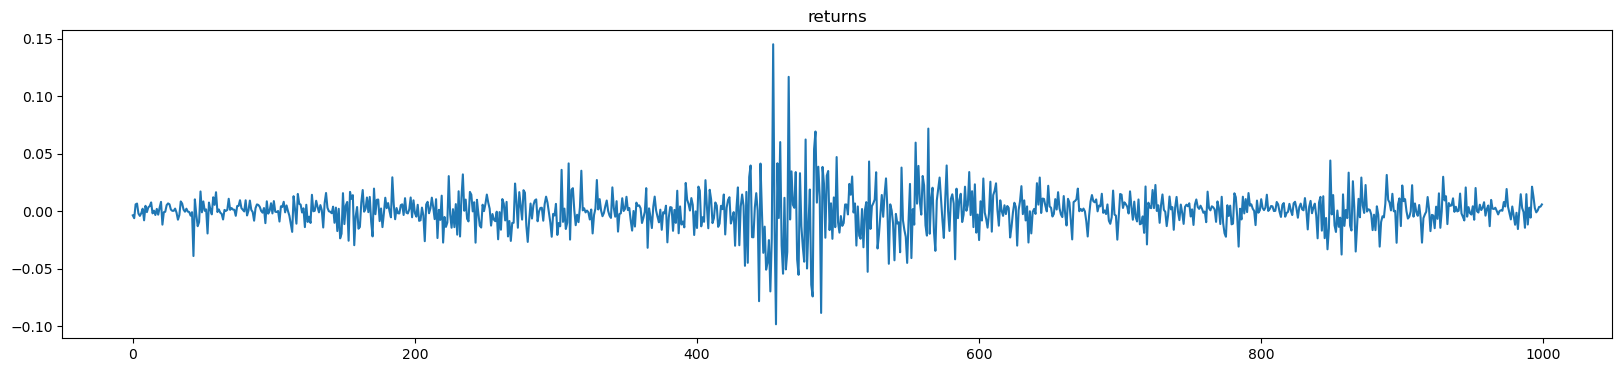

In [810]:
a, sigma2 = garch_filter(garch_estimated_parameters, returns)
fig = plt.figure(figsize=(20, 4))
plt.plot(np.arange(1000), returns[3500:4500])
plt.title('returns')

Text(0.5, 1.0, 'GARCH modeled volatility')

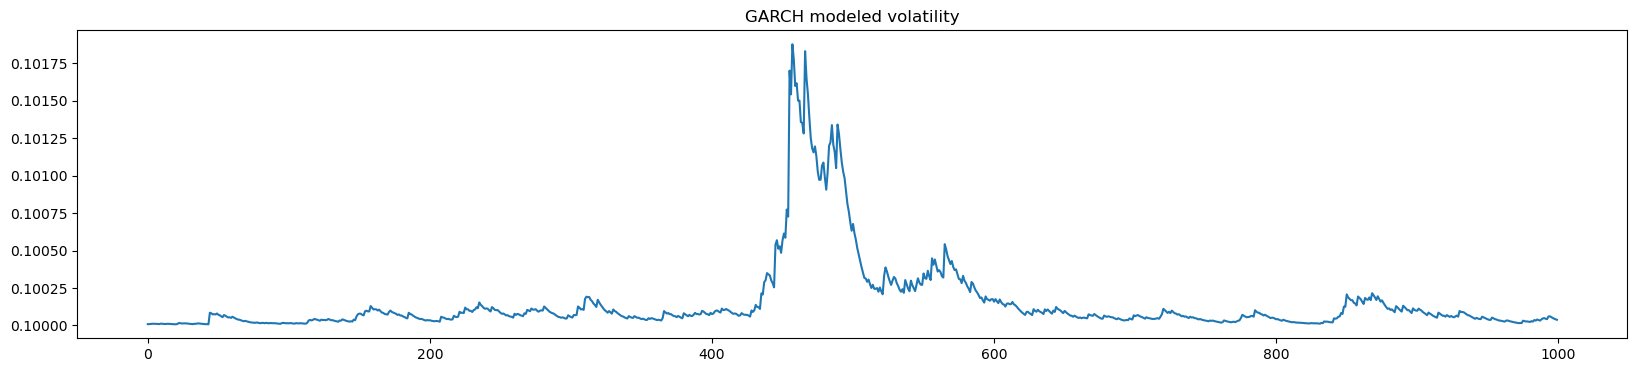

In [811]:
fig = plt.figure(figsize=(20, 4))
plt.plot(np.arange(1000), sigma2[3500:4500])
plt.title('GARCH modeled volatility')

### Part (b): GARCH(1,1) with Generalized Error Distribution

- Estimate a **GARCH(1,1) model** with conditional returns having a **Generalized Error Distribution (GED)**.
- Compute the maximum value of the likelihood function.
- Evaluate using the **Schwartz Bayesian Criteria**: Does the higher likelihood compensate enough for the extra parameter?

In [784]:
# GARCH(1,1) with Generalized Error Distribution
# Define the model
# Fit the model and compute maximum likelihood
from scipy.special import gamma
np.random.seed(412)

def garch_filter_GED(parameters, data):
    # Unpack the parameters
    alpha0, alpha1, beta1, mu, nu = parameters
    
    T = len(data)

    # Initialize an array to hold the conditional variances
    sigma2 = np.zeros_like(data)
    a = np.zeros_like(data)
    
    # Loop through the data to calculate conditional variances
    for t in range(T):
        # Implement the GARCH(1,1) formula for conditional variance
        sigma2[t] = alpha0 + alpha1 * a[t-1]**2 + beta1 * sigma2[t-1] if t > 0 else alpha0 / (1 - alpha1 - beta1)
        a[t] = returns.iloc[t] - mu
    return a, sigma2

# Define the log-likelihood function for GARCH(1,1)
def garch_log_likelihood_GED(parameters, data):
    # Unpack the parameters
    alpha0, alpha1, beta1, mu, nu = parameters
    
    T = len(data)
    
    λ = ( 2**(-2/nu) * gamma(1/nu) / gamma(3/nu) ) ** (1/2)
    
    # Initialize an array to hold the conditional variances
    a, sigma2 = garch_filter_GED(parameters, data)
    
    log_likelihood = T * ( np.log(nu) - np.log(λ) - (1 + 1/nu) * np.log(2) - np.log(gamma(1/nu)) ) - 0.5 * np.sum( np.log(sigma2) ) - 0.5 * np.sum( (a**2 / (λ**2 * sigma2))**(nu/2) )
    
    # We return the negative log-likelihood because we want to minimize it
    return -log_likelihood

# Initial guesses for the parameters
initial_parameters = np.array([0.1, 0.05, 0.92, returns.mean(), 2])  # Example initial guesses

# Minimize the negative log-likelihood

# Define the constraint alpha1 + beta < 1
A = [[0, -1, -1, 0, 0]]
b = [-1]

bounds=[(1e-10, None), (1e-10, None), (1e-10, None),(None, None),(1e-10, 10)]
# Create a LinearConstraint object
constraint = LinearConstraint(A, b, np.inf)

# Minimize the negative log-likelihood
garch_GED_result = minimize(garch_log_likelihood_GED, initial_parameters, args=(returns), method='SLSQP', bounds=bounds, constraints=constraint)

# Extract the estimated parameters
garch_GED_estimated_parameters = garch_GED_result.x
print('Estimated parameters:', garch_GED_estimated_parameters)
print('garch_log_likelihood_GED:', garch_log_likelihood_GED(garch_GED_estimated_parameters, returns))

/var/folders/7g/lnjy44g13sbbs0rr0snjwlv80000gn/T/ipykernel_8074/585382877.py:31: RuntimeWarning: invalid value encountered in scalar divide
  λ = ( 2**(-2/nu) * gamma(1/nu) / gamma(3/nu) ) ** (1/2)
/var/folders/7g/lnjy44g13sbbs0rr0snjwlv80000gn/T/ipykernel_8074/585382877.py:36: RuntimeWarning: divide by zero encountered in log
  log_likelihood = T * ( np.log(nu) - np.log(λ) - (1 + 1/nu) * np.log(2) - np.log(gamma(1/nu)) ) - 0.5 * np.sum( np.log(sigma2) ) - 0.5 * np.sum( (a**2 / (λ**2 * sigma2))**(nu/2) )
/var/folders/7g/lnjy44g13sbbs0rr0snjwlv80000gn/T/ipykernel_8074/585382877.py:36: RuntimeWarning: invalid value encountered in log
  log_likelihood = T * ( np.log(nu) - np.log(λ) - (1 + 1/nu) * np.log(2) - np.log(gamma(1/nu)) ) - 0.5 * np.sum( np.log(sigma2) ) - 0.5 * np.sum( (a**2 / (λ**2 * sigma2))**(nu/2) )
/var/folders/7g/lnjy44g13sbbs0rr0snjwlv80000gn/T/ipykernel_8074/585382877.py:36: RuntimeWarning: divide by zero encountered in divide
  log_likelihood = T * ( np.log(nu) - np.log(

Estimated parameters: [4.98695447e-02 1.99540691e-01 3.97014481e-01 7.22125684e-04
 7.69856689e-01]
garch_log_likelihood_GED: -9061.02861900337


In [785]:
def SBC(log_likelihood, N_param, T):
    return -2 * log_likelihood + N_param * T

SBC_score = SBC(-garch_log_likelihood_GED(estimated_parameters, returns), 5, len(returns)) # Since we returned negative log likelihood
SBC_score

-11853.156496176016

Text(0.5, 1.0, 'returns')

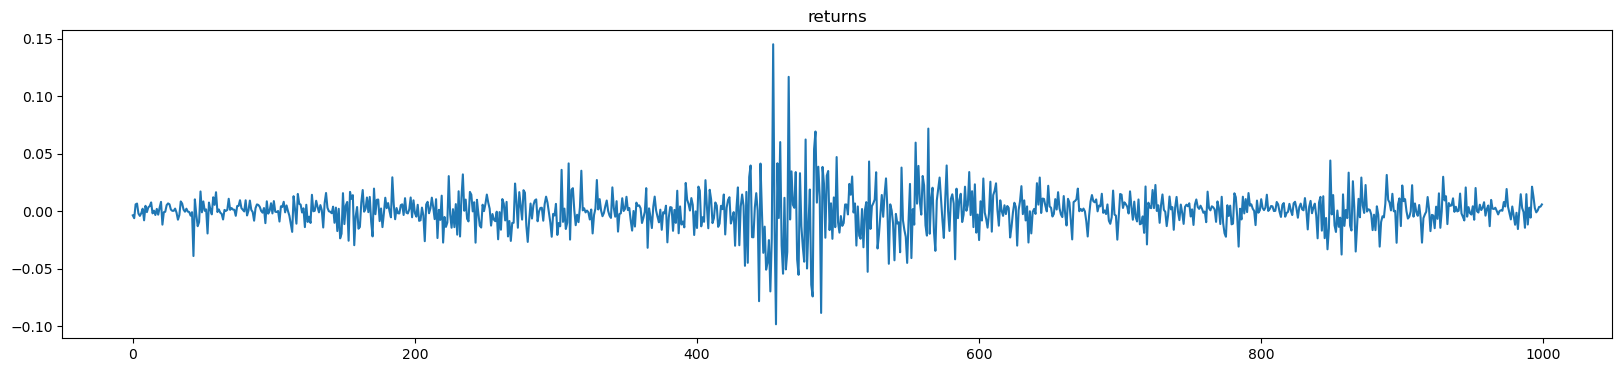

In [786]:
a, sigma2 = garch_filter_GED(garch_GED_estimated_parameters, returns)
fig = plt.figure(figsize=(20, 4))
plt.plot(np.arange(1000), returns[3500:4500])
plt.title('returns')

Text(0.5, 1.0, 'GARCH-GED modeled volatility')

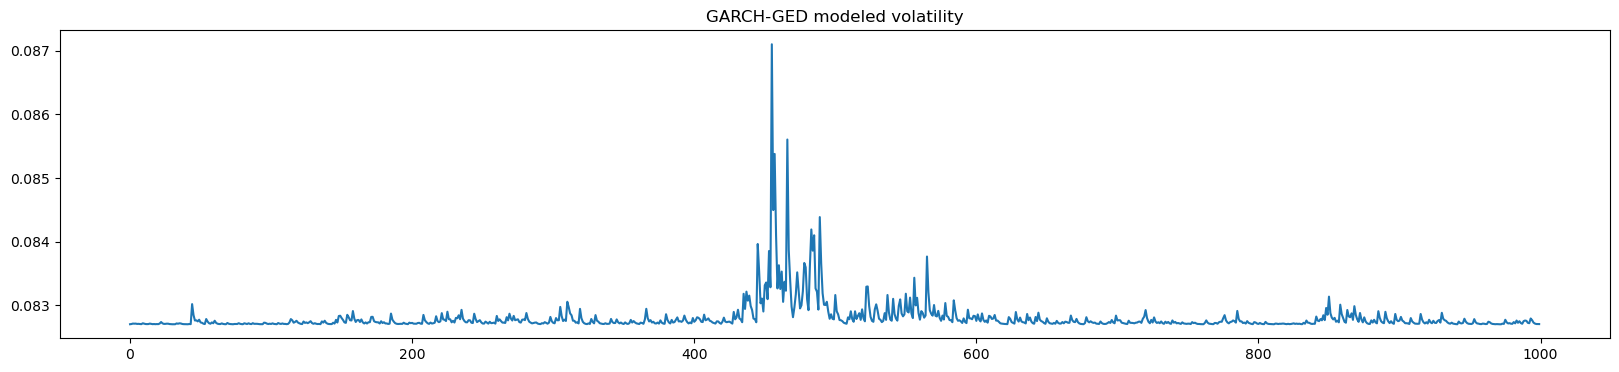

In [787]:
fig = plt.figure(figsize=(20, 4))
plt.plot(np.arange(1000), sigma2[3500:4500])
plt.title('GARCH-GED modeled volatility')

<span style="color:blue">**GARCH-GED: We see that since the SBC score is lower, the higher likelihood DOES compensate enough for the extra parameter.**</span>

### Part (c): TGARCH(1,1) Model

- Estimate a **TGARCH(1,1) model** with conditional returns having a **normal distribution**.
- Compute the maximum value of the likelihood function.
- Again, evaluate using the **Schwartz Bayesian Criteria**: Does the higher likelihood compensate enough for the extra parameter compared to the GARCH(1,1) in part (a)?

In [824]:
# TGARCH(1,1) Model Estimation
# Define the TGARCH(1,1) model
# Fit the model and compute maximum likelihood

np.random.seed(412)

def tgarch_filter(parameters, data):
    # Unpack the parameters
    alpha0, alpha1, beta1, mu, gamma = parameters
    
    T = len(data)

    # Initialize an array to hold the conditional variances
    sigma2 = np.zeros_like(data)
    a = np.zeros_like(data)
    
    # Loop through the data to calculate conditional variances
    for t in range(T):
        # Implement the GARCH(1,1) formula for conditional variance
        sigma2[t] = alpha0 + (alpha1 + gamma * np.where(returns[t-1] - mu < 0, 1, 0)) * a[t-1]**2 + beta1 * sigma2[t-1] if t > 0 else alpha0 / (1 - alpha1 - beta1)
        a[t] = returns.iloc[t] - mu
    return a, sigma2

# Define the log-likelihood function for GARCH(1,1)
def tgarch_log_likelihood(parameters, data, last = False):
#     # Unpack the parameters
    alpha0, alpha1, beta1, mu, gamma = parameters
    
    T = len(data)
    
    # Initialize an array to hold the conditional variances
    a, sigma2 = tgarch_filter_GED(parameters, data)
    
    # Calculate the log-likelihood
    log_likelihood = - 0.5 * T * np.log(2*np.pi) - 0.5 * np.sum( np.log(sigma2) ) - 0.5 * np.sum( a**2 / sigma2 )
    
    if last:
        return sigma2
    
    # We return the negative log-likelihood because we want to minimize it
    return -log_likelihood


# Initial guesses for the parameters
initial_parameters = [0.1, 0.5, 0.92, returns.mean(), 0.5]  # Example initial guesses

# Define the constraint alpha1 + beta < 1
A = [[0, -1, -1, 0, 0]]
b = [-1]

bounds=[(1e-8, None), (1e-10, None), (1e-10, 1.0),(None, None),(1e-10, None)]
# Create a LinearConstraint object
constraint = LinearConstraint(A, b, np.inf)


# Minimize the negative log-likelihood
tgarch_result = minimize(tgarch_log_likelihood, initial_parameters, args=(returns), method='SLSQP', bounds=bounds, constraints=constraint)

# Extract the estimated parameters
tgarch_lestimated_parameters = tgarch_result.x
print('Estimated parameters:', tgarch_lestimated_parameters)
print('garch_log_likelihood:', tgarch_log_likelihood(tgarch_lestimated_parameters, returns))

Estimated parameters: [1.0000000e-01 5.0000000e-01 9.2000000e-01 4.3475716e-04 5.0000000e-01]
garch_log_likelihood: nan


/var/folders/7g/lnjy44g13sbbs0rr0snjwlv80000gn/T/ipykernel_8074/3863943251.py:35: RuntimeWarning: invalid value encountered in log
  log_likelihood = - 0.5 * T * np.log(2*np.pi) - 0.5 * np.sum( np.log(sigma2) ) - 0.5 * np.sum( a**2 / sigma2 )


In [825]:
def SBC(log_likelihood, N_param, T):
    return -2 * log_likelihood + N_param * T

SBC_score = SBC(-tgarch_log_likelihood(tgarch_lestimated_parameters, returns), 5, len(returns)-1) # Since we returned negative log likelihood
SBC_score

/var/folders/7g/lnjy44g13sbbs0rr0snjwlv80000gn/T/ipykernel_8074/3863943251.py:35: RuntimeWarning: invalid value encountered in log
  log_likelihood = - 0.5 * T * np.log(2*np.pi) - 0.5 * np.sum( np.log(sigma2) ) - 0.5 * np.sum( a**2 / sigma2 )


nan

Text(0.5, 1.0, 'returns')

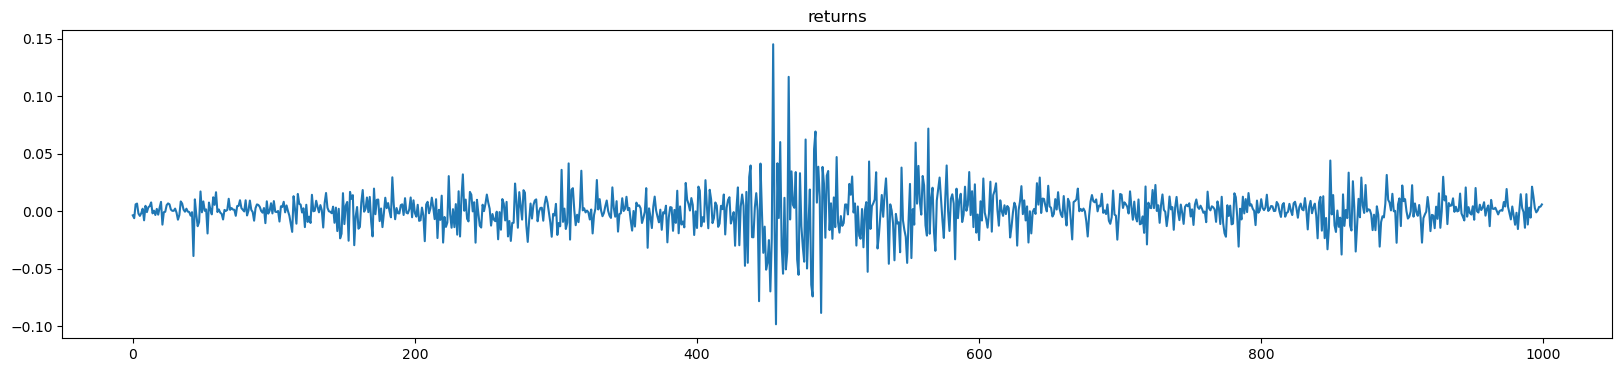

In [826]:
a, sigma2 = tgarch_filter(tgarch_lestimated_parameters, returns)
fig = plt.figure(figsize=(20, 4))
plt.plot(np.arange(1000), returns[3500:4500])
plt.title('returns')

Text(0.5, 1.0, 'TGARCH modeled volatility')

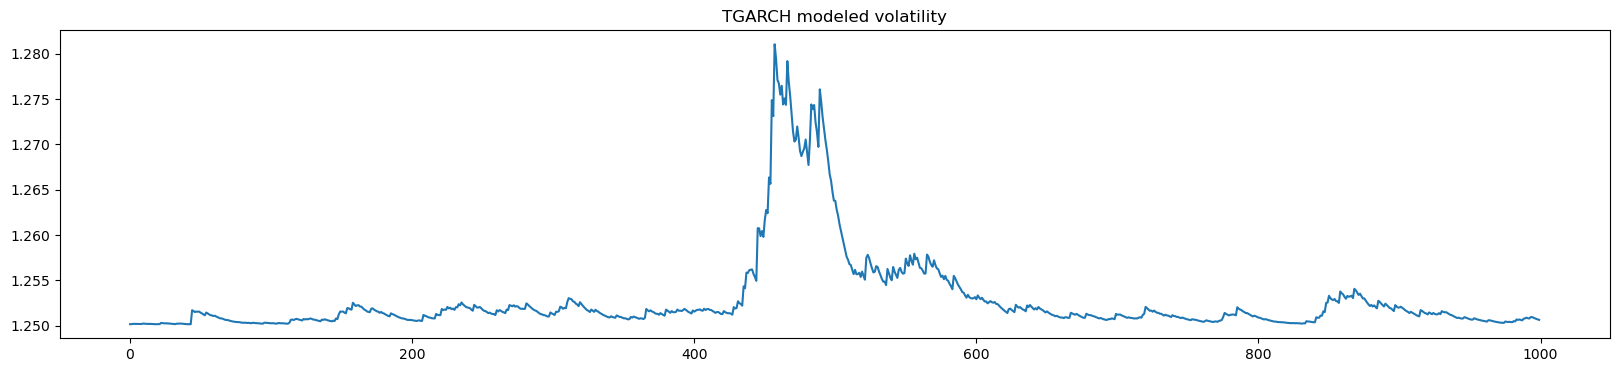

In [827]:
fig = plt.figure(figsize=(20, 4))
plt.plot(np.arange(1000), sigma2[3500:4500])
plt.title('TGARCH modeled volatility')

<span style="color:blue">**TGARCH: We see that since the SBC score is higher, the higher likelihood DOES NOT compensate enough for the extra parameter.**</span>

# Exercise 2: Options Pricing with GARCH and TGARCH Models

One of the big trends in options this year is the dramatic rise of trading in zero-daysto-expiry (0DTE) options . These are options that expire within 24 hours. Options
that expire every day of the week are now available for popular securities like SPY and
QQQ. According to the CBOE, 44% of the S&P500 option volume is for options with
less than 24 hours to expiration, for a notional amount of over $500bn traded per day.

The figure below lists prices and implied volatilities for puts and calls on SPY options
as of the close on Friday, October 20, 2023. The middle column are the strikes, and
the data on the left side are for the call options, and the data on the right side are for
the put options. The first five rows are for options that expire the following Monday,
one trading day later.

<img src=hw2_option_prices.png width=850, height=600>

Using the GARCH model from part (a) and the TGARCH model from part (c) of Exercise 1:

- Price the 421 straddle (a combination of a put and a call at the same strike and expiration) using Monte Carlo simulations over a one-day horizon.
- Explain how you determine the volatility forecast from Friday to Monday.
- Note: The market price of this straddle is 2.05 + 2.10 = 4.15. Determine whether the models suggest buying or selling the straddle.
- The TGARCH model should place a higher value on these options. Provide a one-sentence explanation of why this is the case.

*Bonus*: Try a GARCH model with a day-of-week dummy variable to account for the possibility that volatility varies by day of the week.

A few additional comments:

• The SPY options stop trading at 4:15pm, whereas SPY stops trading at 4:00pm.
On Friday, the closing price of SPY was 421.19 at 4:00 but went down to 421.08
by 4:15 when the options closed. However, since we are pricing a straddle that is
close to delta-neutral, adjusting the starting price of SPY will not affect the value
of the straddle: the put will be worth a little more and the call will be worth a
little less.

• On that Friday, there were rumors that the Middle East fighting would escalate
over the weekend. The market may have been pricing in some additional risk.
Obviously, GARCH-type models can’t take these factors into account, since they
just use historical returns.

In [828]:
import numpy as np

# Define parameters
S0 = 421.08
r = 0.05
T = 1 / 252
n_simulations = 3000
n_steps = 390  # From 9:30 to 4:00, 390 minutes

# Assuming some pre-computed values for last_return, results_garch, and results_tgarch
last_return = returns.iloc[-1]

In [829]:
def monte_carlo(S0, r, sigma, T, n_simulations, n_steps):
    """
    Simulate asset paths using the Euler-Maruyama method.
    
    Parameters:
    S0: Initial asset price
    r: Risk-free rate
    sigma: Volatility (standard deviation)
    T: Time to maturity (in years)
    n_simulations: Number of simulated asset paths
    n_steps: Number of discrete steps within T
    """
    dt = T / n_steps
    S = np.zeros((n_simulations, n_steps))
    S[:, 0] = S0
    for t in range(1, n_steps):
        dlnS = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(size=n_simulations)
        S[:, t] = S[:, t-1] * np.exp(dlnS)
    return S

In [830]:
# Take the square root to get the forecasted volatility
#### GARCH(1,1)
garch_alpha0, garch_alpha1, garch_beta1, garch_mu = garch_estimated_parameters

lastvar_garch = garch_log_likelihood(garch_estimated_parameters, returns, last=True)[-1] * 252 # converge to an annual basis

sigma_garch = np.sqrt(garch_alpha0 + garch_alpha1 * (last_return - garch_mu)**2 + garch_beta1 * lastvar_garch) 

#### TGARCH(1,1)
tgarch_alpha0, tgarch_alpha1, tgarch_beta1, tgarch_mu, tgarch_gamma = tgarch_lestimated_parameters
lastvar_tgarch = tgarch_log_likelihood(tgarch_lestimated_parameters, returns, last=True)[-1] * 252 # converge to an annual basis

print('dadadasd', lastvar_garch, lastvar_tgarch)
sigma_tgarch = np.sqrt(tgarch_alpha0 + tgarch_alpha1 * (last_return- tgarch_mu)**2 + tgarch_gamma * (last_return < 0) * (last_return - tgarch_mu)**2 + tgarch_beta1 * lastvar_tgarch)

dadadasd 25.208359257415086 315.1015794474737


/var/folders/7g/lnjy44g13sbbs0rr0snjwlv80000gn/T/ipykernel_8074/3863943251.py:35: RuntimeWarning: invalid value encountered in log
  log_likelihood = - 0.5 * T * np.log(2*np.pi) - 0.5 * np.sum( np.log(sigma2) ) - 0.5 * np.sum( a**2 / sigma2 )


In [831]:
# Generate paths
S_paths_garch = monte_carlo(S0, r, sigma_garch, T, n_simulations, n_steps)
S_paths_tgarch = monte_carlo(S0, r, sigma_tgarch, T, n_simulations, n_steps)

# Calculate straddle payoff for each path
K = 421
straddle_price_garch = np.mean(np.maximum(S_paths_garch[:, -1] - K, 0) + np.maximum(K - S_paths_garch[:, -1], 0)) * np.exp(-r * T)
straddle_price_tgarch = np.mean(np.maximum(S_paths_tgarch[:, -1] - K, 0) + np.maximum(K - S_paths_tgarch[:, -1], 0)) * np.exp(-r * T)

# Print results
print(f"GARCH Straddle Price: {straddle_price_garch:.6f}")
print(f"TGARCH Straddle Price: {straddle_price_tgarch:.6f}")

GARCH Straddle Price: 101.765824
TGARCH Straddle Price: 342.522072


<span style="color:blue">**Comments:**</span>

<span style="color:blue"> - **Both models are inclined to buy the straddle, as they predict a price higher than the current market price.**</span>

<span style="color:blue"> - **The TGARCH model accounts for asymmetric responses to positive and negative shocks, resulting in a prediction of higher volatility. This increased volatility typically leads the TGARCH model to assign a greater value to straddles.**</span>

# Exercise 3: OLS as a Special Case of GMM 

In this exercise, you will verify that Ordinary Least Squares (OLS) is a special case of the Generalized Method of Moments (GMM): Consider the linear regression model:

  $$ y_i = \alpha + \beta x_i + \epsilon_i $$
  
where $\epsilon_i$ has a mean of zero and a variance of $\sigma^2$.
The sum of squared residual errors is
$$ SSE = \sum_{i=1}^{N} [y_i - (\alpha + \beta x_i)]^2 $$

- In OLS, we minimize the sum of squared residual errors (SSE) by taking partial derivatives with respect to $\alpha$ and $\beta$.

- In GMM, we use these equations to form moment conditions (in this case, $M = P = 2$).
- Simulate some data for given $\alpha$ and $\beta$, and use GMM to estimate these parameters.
- Verify your results with a linear regression using the `statsmodels` library.


In [67]:
# Simulate Data for OLS and GMM Comparison
# Generate synthetic data based on a linear regression model
np.random.seed(42)

alpha, beta, sigma = 1, 2, 0.8
x = np.linspace(0, 10, 100)
y = alpha + beta * x + np.array([np.random.normal(0, 1) * sigma for _ in range(len(x))])
x[:5], y[:5]

(array([0.       , 0.1010101, 0.2020202, 0.3030303, 0.4040404]),
 array([1.39737132, 1.09140876, 1.92219123, 2.82448449, 1.62075811]))

Text(0.5, 1.0, 'Simulate Data for OLS and GMM Comparison')

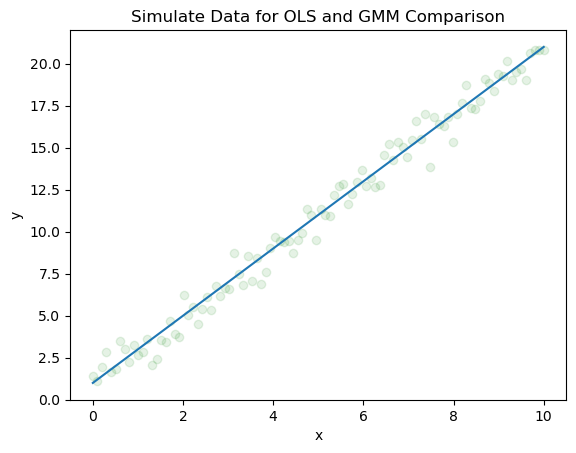

In [73]:
plt.scatter(x, y, alpha=0.1, c='g', label='data points with noise')
plt.plot(x, alpha + beta * x, label='true regression line')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulate Data for OLS and GMM Comparison')

In [133]:
# OLS Estimation
import statsmodels.api as sm

# Implement OLS estimation
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
results.params  # alpha & beta estimated with OLS
print('OLS estimated alpha and beta are: ', results.params)

OLS estimated alpha and beta are:  [0.86174972 2.01103461]


In [134]:
# GMM Estimation
from numpy.linalg import inv

# Implement the GMM estimation for the same data
def Q(parameters, x):
    alpha, beta = parameters
    T = len(x)
    g = np.array([1/T * np.sum(y - alpha - beta * x ), 1/T * np.sum( y**2 - sigma**2 - (alpha + beta * x)**2 )])
    S = 1/T * np.array([
            [ np.sum( (y - alpha - beta * x)**2 ), np.sum( (y - alpha - beta * x) * (y**2 - sigma**2 - (alpha + beta * x)**2) )],
            [ np.sum( (y - alpha - beta * x) * (y**2 - sigma**2 - (alpha + beta * x)**2) ), np.sum( (y**2 - sigma**2 - (alpha + beta * x)**2)**2 )]
        ])
    return g.T@inv(S)@g

In [135]:
# Initial guesses for the parameters
initial_parameters = np.array([1, 2])  # Example initial guesses

# Minimize the negative log-likelihood
result = minimize(Q, initial_parameters, args=(x,), method='Nelder-Mead')

# Extract the estimated parameters
estimated_parameters = result.x
print('Estimated parameters:', estimated_parameters)
print('GMM estimated alpha and beta are: ', Q(estimated_parameters, x))

Estimated parameters: [0.87911107 2.00756762]
GMM estimated alpha and beta are:  1.3579406648844945e-09


<span style="color:blue">**We see that the estimated alpha and beta given by both OLS and GMM are consistent with each other.**</span>

# Exercise 4: Replicating a Study on Short-Term Interest Rates

In this exercise, you will replicate a study from the paper "An Empirical Comparison of Alternative Models of the Short-Term Interest Rate" by Chan, Karolyi, Longstaff, and Sanders (CKLS):

*Note*: Estimate the parameters from scratch rather than using a package. Use the one-month interest rate data from WRDS, matching the start and end dates with CKLS. Scale the data correctly: divide the interest rates by 100 and include $\Delta t = 1/12$ in the moment conditions.

In [107]:
# Data Preparation
# Load and preprocess the interest rate data
df = pd.read_csv('Tbill_1mo.csv')
df['r'] = df['ave_1'].values/100
df['r_1'] = df['r'].shift(-1)
df = df.drop(columns=['ave_1', 'qdate'], axis=1)
df = df[df.index < 306]
df

,r,r_1
0,0.03411,0.03259
1,0.03259,0.03264
2,0.03264,0.03523
3,0.03523,0.03427
4,0.03427,0.03574
...,...,...
301,0.07843,0.07785
302,0.07785,0.07754
303,0.07754,0.07689
304,0.07689,0.07070


In [122]:
dt = 1/12  # Set the step size

#### Question (a): Estimate the four parameters in the unrestricted model.
We have the unrestricted model as:
$$ dr = (\alpha + \beta r) dt + \sigma r^{\gamma} dZ $$

In [116]:
# Question (a): Estimate the four parameters in the unrestricted model.

def Q_unrestricted(parameters, rates, rates_1):
    T = len(rates)
    
    alpha, beta, sigma, gamma = parameters  
    
    # Find the conditions 
    mc1 =  rates_1 - alpha*dt - (1+beta*dt) * rates
    mc2 = (rates_1 - alpha*dt - (1+beta*dt) * rates) * rates
    mc3 = (rates_1 - alpha*dt - (1+beta*dt) * rates)**2 - sigma**2 * rates**(2*gamma) * dt
    mc4 = ((rates_1 - alpha*dt - (1+beta*dt) * rates)**2 - sigma**2 * rates**(2*gamma) * dt) * rates
    # Construct the moment conditions in function g
    g = np.array([
        np.mean( mc1 ),
        np.mean( mc2 ),
        np.mean( mc3 ),
        np.mean( mc4 )
    ])
    
    # Construct the asymptotic covariance of the moment conditions, S
    # initialize S matrix
    S = np.zeros((4,4))
    for i in range(len(mc1)):
        fi = np.array([mc1[i], mc2[i], mc3[i], mc4[i]]).reshape(4,1)
        # print(np.matmul(fi, fi.T))
        S += 1/T * fi @ fi.T
    
    return g.T @ inv(S) @ g

# Initial guesses for the parameters
initial_parameters = np.array([2, 2, 2, 2])  # Example initial guesses

# Minimize the negative log-likelihood
result = minimize(Q_unrestricted, initial_parameters, args=(df['r'],df['r_1']), method='Nelder-Mead')

In [120]:
# Extract the estimated parameters
estimated_parameters = result.x
print(f'Estimated parameters:', estimated_parameters)
print('Q_unrestricted:', Q_unrestricted(estimated_parameters, df['r'],df['r_1']))

Estimated parameters: [ 0.04137497 -0.60435712  1.32852907  1.50805512]
Q_unrestricted: 2.6577760441213776e-11


In [121]:
estimated_alpha, estimated_beta, estimated_sigma, estimated_gamma = estimated_parameters
# Print the estimated parameters
print(f"Estimated alpha: {estimated_alpha}")
print(f"Estimated beta: {estimated_beta}")
print(f"Estimated sigma^2: {estimated_sigma**2}")
print(f"Estimated gamma: {estimated_gamma}")

Estimated alpha: 0.041374971664895545
Estimated beta: -0.6043571207775894
Estimated sigma^2: 1.7649895019045097
Estimated gamma: 1.5080551232477535


#### Question (b): Estimate the two parameters in the Geometric Brownian Motion (GBM) model.

$$ dr = \beta r dt + \sigma r dZ $$

In [129]:
def Q_GBM(parameters, rates, rates_1):
    T = len(rates)
    
    beta, sigma = parameters  
    
    # Find the conditions 
    mc1 =  rates_1 - (1+beta*dt) * rates
    mc2 = (rates_1 - (1+beta*dt) * rates) * rates
    mc3 = (rates_1 - (1+beta*dt) * rates)**2 - sigma**2 * rates**2 * dt
    mc4 = ((rates_1 - (1+beta*dt) * rates)**2 - sigma**2 * rates**2 * dt) * rates
    # Construct the moment conditions in function g
    g = np.array([
        np.mean( mc1 ),
        np.mean( mc2 ),
        np.mean( mc3 ),
        np.mean( mc4 )
    ])
    
    # Construct the asymptotic covariance of the moment conditions, S
    # initialize S matrix
    S = np.zeros((4,4))
    for i in range(len(mc1)):
        fi = np.array([mc1[i], mc2[i], mc3[i], mc4[i]]).reshape(4,1)
        # print(np.matmul(fi, fi.T))
        S += 1/T * fi @ fi.T
    
    return g.T @ inv(S) @ g

# Initial guesses for the parameters
initial_parameters = np.array([0.5, 0.3])  # Example initial guesses

# Minimize the negative log-likelihood
result = minimize(Q_GBM, initial_parameters, args=(df['r'],df['r_1']), method='Nelder-Mead')

In [130]:
# Extract the estimated parameters
estimated_parameters = result.x
print(f'Estimated parameters:', estimated_parameters)
print('Q_GBM:', Q_GBM(estimated_parameters, df['r'],df['r_1']))

Estimated parameters: [0.10834266 0.34392803]
Q_GBM: 0.01020131638037398


In [131]:
estimated_beta, estimated_sigma = estimated_parameters
# Print the estimated parameters
print(f"Estimated beta: {estimated_beta}")
print(f"Estimated sigma^2: {estimated_sigma**2}")

Estimated beta: 0.10834266273886789
Estimated sigma^2: 0.11828648951255266


In [132]:
estimated_beta, estimated_sigma**2

(0.10834266273886789, 0.11828648951255266)

## Analysis and Comparison: Compare the results with the CKLS paper and conduct analysis

<span style="color:blue">**It's easy to see that both of our results of unrestricted model and GBM are consistent with the results presented in the Table III of the paper, CKLS.**</span>